In [5]:
import pandas as pd
import numpy as np
import itertools
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import timeit
import csv
import os
import string
import textblob
import requests
import io
import nltk

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA

from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, auc
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import preprocessing
from sklearn import decomposition, ensemble

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from importlib import reload
# reload(text_processing)


# nlp = spacy.load('en') # loading the language model 
#data = pd.read_feather('data/preprocessed_data') # reading a pandas dataframe which is stored as a feather file


%matplotlib inline
# sns.set_context('poster')
# sns.set_color_codes()
full_path_data_store = '/home/silas/final_project/Data/'

#### load data

In [9]:
with open(full_path_data_store +'df_datasets.pickle', 'rb') as handle:
    df_datasets = pickle.load(handle)

### Runs

> binary ('bin')
   - toy datasets (e.g. 'bin_spam')
   - climate merged ('bin_mgd')
       + 'science' (e.g. 'bin_mgd_science')

> multi-class as binary ('mult_bin') \ use binarization cell below
   - toy datasets (e.g. 'mult_bin_bbc')
   - climate_merged ('mult_bin_mgd')
       + 'science' ('mult_bin_mgd_science')

> multi-class as multi-class ('mult_mult')
   - toy datasets (e.g. 'mult_mult_bbc')
   - climate_merged ('mult_mult_mgd')
       + 'science' ('mult_mult_mgd_science')
    
    

In [10]:
# available datasets
list(df_datasets.keys())

['climate', 'spam', 'newsgroups', 'reuters', 'bbc', 'science']

In [8]:
# enter run title here
run_title = input('provide title of run: ')
# make dir for saves
os.mkdir('Output/'+run_title)
# enter dataset
df_name_=input('provide dataset name: ')

provide title of run: bin_spam
provide dataset name: spam


In [9]:
#Example: 
df_datasets[df_name_].groupby('labels')[['texts']].count()

,texts
labels,
0,4327
1,562


### Data splits

In [10]:
# split dataframe into text and labels

def pre_split_data(df):
    texts = df.texts
    labels = df.labels
    processed_texts = df.processed_text
    return  texts,labels,processed_texts


texts,labels,processed_texts=pre_split_data(df_datasets[df_name_])

In [11]:
# UNPROCESSED: raw text, split the dataset into training and validation datasets 
train_x, valid_x, train_y_text_label, valid_y_text_label = train_test_split(texts, labels)

# PROCESSED: preprocessed text, split the dataset into training and validation datasets 
train_xp, valid_xp, train_yp_text_label, valid_yp_text_label = train_test_split(processed_texts, labels)

# label encode the target variable for raw and processed datasets
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y_text_label)
valid_y = encoder.fit_transform(valid_y_text_label)
train_yp = encoder.fit_transform(train_yp_text_label)
valid_yp = encoder.fit_transform(valid_yp_text_label)

In [12]:
# dictionary of recording run times for models
time_keeper={}

### Binarize data labels
- binary classification --> takes one category (ex: label '1') and makes '1' all others '0'

In [11]:
# run if binary experiment

binary=input('enter 1 to binarize ')

def binarize(train_y,valid_y,train_yp,valid_yp):
    
    train_y = np.array((pd.DataFrame({'t_label':train_y}).t_label == 1).astype('int'))
    valid_y = np.array((pd.DataFrame({'t_label':valid_y}).t_label == 1).astype('int'))
    train_yp = np.array((pd.DataFrame({'t_label':train_yp}).t_label == 1).astype('int'))
    valid_yp = np.array((pd.DataFrame({'t_label':valid_yp}).t_label == 1).astype('int'))
    
    return train_y,valid_y,train_yp,valid_yp

if binary=='1':
    print('binarizing data...')
    train_y,valid_y,train_yp,valid_yp=binarize(train_y,valid_y,train_yp,valid_yp)
    print('finished')
    # class counts for binarized df
    print("valid: positive class {}\nnegative class {}".format(len(valid_y[valid_y==1]),len(valid_y[valid_y==0])))

enter 1 to binarize 


## Feature Engineering

[reference](#https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/)

<a id='vectorizing'></a>

#### Vectorizing: 
[reference](#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- Analyzer, "word" or "char"
- Strip out stop words (ex: "english").
- Filter out terms that occur in more than half of the docs (ex: max_df=0.5)
- Filter out terms that occur in only one document (min_df=2).
- Select the N most frequently occuring words in the corpus.
- default for tfidf - normalize the vector (L2 norm of 1.0) to normalize the effect of document length on the tf-idf values.

In [13]:
# params take form of (analyzer, token pattern, stop_words)

def run_vectorizer(train_x_,valid_x_, model, params):

    # create a vectorizer object 
    if model == CountVectorizer:
        print('count vectorizing...')
        vect = model(analyzer=params[0], token_pattern=params[1], stop_words=params[2], 
                     lowercase=params[3], ngram_range=params[4])
    
    else:
        print('tfidf vectorizing...')
        vect = model(model(analyzer=params[0], max_df=params[1], min_df=params[2], max_features=params[3], 
          stop_words=params[4], use_idf=params[5]), token_pattern=params[6], ngram_range=params[7])
    
    if processed=='1':
        print('fitting processed texts')
        vect.fit(processed_texts)
        
    else:
        vect.fit(texts)

    # transform the training and validation data using count vectorizer objectea
    xtrain_ =  vect.transform(train_x_)
    xvalid_ =  vect.transform(valid_x_)
    
    return xtrain_, xvalid_

### Count Vectors

In [14]:
#select processed or unprocessed text data
processed=input('for processed data, enter 1 ')

for processed data, enter 1 


In [15]:
start_time = timeit.default_timer()

# count vectorizer params
model_count = CountVectorizer

params_count1 = ('word', r'\w{1,}', 'english', True, (1,1))
params_count2 = ('char', r'\w{1,}', 'english', True, (1,1))
params_count3 = ('word', r'\w{1,}', 'english', True, (2,3))
params_count4 = ('char', r'\w{1,}', 'english', True, (2,3))

if processed=='1':
    print('vectorizing processed text data...')
    xtrain_count,xvalid_count= run_vectorizer(train_xp,valid_xp, model_count, params_count1)
    xtrain_count_char,xvalid_count_char = run_vectorizer(train_xp,valid_xp, model_count, params_count2)
    xtrain_count_ngram,xvalid_count_ngram = run_vectorizer(train_xp,valid_xp, model_count, params_count3)
    xtrain_count_ngram_chars,xvalid_count_ngram_chars = run_vectorizer(train_xp,valid_xp, model_count, params_count4)

else:
    print('vectorizing unprocessed text data')
    xtrain_count,xvalid_count= run_vectorizer(train_x,valid_x, model_count, params_count1)
    xtrain_count_char,xvalid_count_char = run_vectorizer(train_x,valid_x, model_count, params_count2)
    xtrain_count_ngram,xvalid_count_ngram = run_vectorizer(train_x,valid_x, model_count, params_count3)
    xtrain_count_ngram_chars,xvalid_count_ngram_chars = run_vectorizer(train_x,valid_x, model_count, params_count4)

# code you want to evaluate

elapsed = timeit.default_timer() - start_time
time_keeper['count_vectorization'] = elapsed

vectorizing unprocessed text data
count vectorizing...
count vectorizing...
count vectorizing...
count vectorizing...


### TF-IDF Vectors
 

In [16]:
#select processed or unprocessed text data for tfidf vectorization
start_time = timeit.default_timer()

# tfidf vectorizer params

model_tfidf = TfidfVectorizer

params_tfidf1 = ('word',0.9,2,5000,'english',True, r'\w{1,}', (1,1))
params_tfidf2 = ('char',0.9,2,5000,'english',True, r'\w{1,}', (1,1))
params_tfidf3 = ('word',0.9,2,5000,'english',True, r'\w{1,}', (2,3))
params_tfidf4 = ('char',0.9,2,5000,'english',True, r'\w{1,}', (2,3))

if processed==1:
    print('vectorizing processed text data ')
    xtrain_tfidf,xvalid_tfidf= run_vectorizer(train_xp,valid_xp, model_tfidf, params_tfidf1)
    xtrain_tfidf_char,xvalid_tfidf_char = run_vectorizer(train_xp,valid_xp, model_tfidf, params_tfidf2)
    xtrain_tfidf_ngram,xvalid_tfidf_ngram = run_vectorizer(train_xp,valid_xp, model_tfidf, params_tfidf3)
    xtrain_tfidf_ngram_chars,xvalid_tfidf_ngram_chars = run_vectorizer(train_xp,valid_xp, model_tfidf, params_tfidf4)
    
else:
    print('vectorizing unprocessed text data ')
    xtrain_tfidf,xvalid_tfidf= run_vectorizer(train_x,valid_x, model_tfidf, params_tfidf1)
    xtrain_tfidf_char,xvalid_tfidf_char = run_vectorizer(train_x,valid_x, model_tfidf, params_tfidf2)
    xtrain_tfidf_ngram,xvalid_tfidf_ngram = run_vectorizer(train_x,valid_x, model_tfidf, params_tfidf3)
    xtrain_tfidf_ngram_chars,xvalid_tfidf_ngram_chars = run_vectorizer(train_x,valid_x, model_tfidf, params_tfidf4)

    
elapsed = timeit.default_timer() - start_time
time_keeper['tfidf_vectorization'] = elapsed

vectorizing unprocessed text data 
tfidf vectorizing...
tfidf vectorizing...
tfidf vectorizing...
tfidf vectorizing...


[jump to models](#models)

### Text / NLP based features

In [16]:
def get_NLP_features(texts, normed_=True):

    trainDF=pd.DataFrame()
    trainDF['char_count'] = texts.apply(len)
    trainDF['word_count'] = texts.apply(lambda x: len(x.split()))
    trainDF['word_density'] = trainDF['char_count'] / (trainDF['word_count']+1)
    trainDF['punctuation_count'] = texts.apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation))) 
    trainDF['title_word_count'] = texts.apply(lambda x: len([wrd for wrd in x.split() if wrd.istitle()]))
    trainDF['upper_case_word_count'] = texts.apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))
    
    pos_family = {
        'noun' : ['NN','NNS','NNP','NNPS'],
        'pron' : ['PRP','PRP$','WP','WP$'],
        'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
        'adj' :  ['JJ','JJR','JJS'],
        'adv' : ['RB','RBR','RBS','WRB']
    }
    
    # function to check and get the part of speech tag count of a words in a given sentence
    def check_pos_tag(x, flag):
        cnt = 0
        try:
            wiki = textblob.TextBlob(x)
            for tup in wiki.tags:
                ppo = list(tup)[1]
                if ppo in pos_family[flag]:
                    cnt += 1
        except:
            pass
        return cnt
    
    trainDF['noun_count'] = texts.apply(lambda x: check_pos_tag(x, 'noun'))
    trainDF['verb_count'] = texts.apply(lambda x: check_pos_tag(x, 'verb'))
    trainDF['adj_count'] = texts.apply(lambda x: check_pos_tag(x, 'adj'))
    trainDF['adv_count'] = texts.apply(lambda x: check_pos_tag(x, 'adv'))
    trainDF['pron_count'] = texts.apply(lambda x: check_pos_tag(x, 'pron'))
    
    if normed_:
        
        x = trainDF.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        trainDF_normed = pd.DataFrame(x_scaled,columns=trainDF.columns)
        trainDF_normed.to_pickle('Other/{}_nlp_features_normed'.format(run_title))
        
        return trainDF_normed
    
    time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    trainDF.to_pickle('Output/{}/{}_nlp_features_{}'.format(run_title,run_title, df_name_))
    
    return trainDF 

In [17]:
NLP_features = get_NLP_features(train_x,normed_=False)

NameError: name 'df_name' is not defined

In [ ]:
NLP_features.head()

### Topic Model

-  https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [18]:
def list_dictionary(dictionary, n=10):
    '''
    Returns: the first n words from dictionary 
    '''
    
    count = 0
    for k, v in dictionary.iteritems():
        print(k, v)
        count += 1
        if count > n:
            break
            
# list_dictionary(dictionary, top=10)

In [ ]:
def inspect_corpus_doc(corpus,doc_to_insp):
    """
    Inspect a doc in the corpus for word frequencies
    Args
        corpus: corpus
        doc_to_insp: int value to show n docs  
    Return
        None
    """
    
    doc_insp = corpus[doc_to_insp]
    for i in range(len(doc_insp)):
        print("Word {} (\"{}\") score {}".format(doc_insp[i][0],dictionary[doc_insp[i][0]],doc_insp[i][1]))

In [ ]:
# print topics from lda_model
def get_topics(model):
    for idx, topic in model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))
# get_topics(lda_model)

In [ ]:
# inspect where doc in corpus would be classified/assigned topic probability
def lda_in_doc_classification(model, corpus, doc_num):
    for index, score in sorted(model[corpus[doc_num]], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTopic: {}".format(score, model.print_topic(index, 10)))
# lda_in_doc_classification(lda_model, bow_corpus, 20)
# lda_in_doc_classification(lda_model_tfidf, bow_corpus, 100)

In [ ]:
def lda_out_doc_classification(unseen_document):
    """
    Takes a list of a single doc string
    example: unseen_document = ['The night love tomorrow']
    Args
        unseen_document: single list of tokens
    """
    from text_processing import preprocess_spacy
    text = preprocess_spacy(pd.DataFrame({'texts': unseen_document})).str.split()[0]
    bow_vector = dictionary.doc2bow(text)
    for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
        print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

In [ ]:
# build dictionary, bow corpus, and tfidf corpus (using bow corpus)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel,LdaMulticore
dictionary = Dictionary(processed_texts.str.split())
dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in train_xp.str.split()]
tfidf = TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [ ]:
inspect_corpus_doc(bow_corpus,1)

In [ ]:
inspect_corpus_doc(corpus_tfidf,1)

In [ ]:
# Running LDA using Bag of Words
lda_model = LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [ ]:
# Running LDA using TF-IDF
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [ ]:
get_topics(lda_model_tfidf)

In [ ]:
lda_model_tfidf.show_topics(10)
# lda_model_tfidf.get_topics().shape

In [ ]:
unseen_document=['Climate policy jurisdiction based reform']
lda_out_doc_classification(unseen_document)

#### LDA TFIDF similarity

In [ ]:
from nltk import word_tokenize
query_doc = [w.lower() for w in word_tokenize("here is good place to stay.")]
print(query_doc)
query_doc_bow = dictionary.doc2bow(query_doc)
print(query_doc_bow)
query_doc_tf_idf = tfidf[query_doc_bow]
print(query_doc_tf_idf)


In [ ]:
# TFIDF
# https://www.oreilly.com/learning/how-do-i-compare-document-similarity-using-python
# TFIDF = TfidfModel(corpus)
from gensim.similarities import Similarity
sims = Similarity('temp' , corpus_tfidf, num_features = len(dictionary))
sim_output= sims[query_doc_tf_idf]
sim_output = sorted(enumerate(sim_output), key=lambda item: -item[1])
        
# inspect_corpus(corpus,1704)

In [ ]:
len(sim_output)

In [ ]:
"""
q_doc_TFIDF = tfidf[q_doc]
temp_lst=[]
for idx,i in enumerate(sims[q_doc_TFIDF]):
    if i != 0.:
        temp_lst.append((idx,i))
"""

<a id='models'></a>
<a id='inspect_train_models'></a>
[inspect_vectorizing](#vectorizing)

## -Models
- run all functions below

In [17]:
def train_model(classifier, train_x_, train_y_, valid_x_, valid_y_, is_neural_net=False):
    # fit the training dataset on the classifier
    print('Running model...')
    start_time = timeit.default_timer()
    
    
    if is_neural_net:
        result = classifier.fit(train_x_, train_y_, epochs=4, validation_split=0.2)
        y_predicted = classifier.predict(valid_x_)
        y_predicted = (y_predicted > .12) # y_predicted.argmax(axis=-1)
        
    else:
        result = classifier.fit(train_x_, train_y_)
        # predict the labels on validation dataset
        y_predicted = classifier.predict(valid_x_)
    
    # record results here
    elapsed = timeit.default_timer() - start_time
    plot_confusion_matrix(valid_y_, y_predicted)
    print('Fetching report...')
    report = classification_report(valid_y_, y_predicted) 
    lines = report.split('\n')
    report_data = []
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[1]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = int(row_data[5])
        row['time_secs'] = elapsed
        report_data.append(row)
    dataframe = pd.DataFrame(report_data)
    
    if is_neural_net: 
        fig, axs = plt.subplots(1,1)
        plot_loss(result)
        plot_accuracy(result)
        
    
    return dataframe,result

In [18]:
def plot_accuracy(result,savefig_=True):
    plt.plot(result.history['acc'])
    plt.plot(result.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.show()
    
    if savefig_:
        time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
        plt.savefig('Output/{}/accuracy_plot_{}_{}.png'.format(run_title,run_title,time_))
        
        
def plot_loss(result,savefig_=True):
    plt.plot(result.history['loss'])
    plt.plot(result.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()
    
    if savefig_:
        time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
        plt.savefig('Output/{}/loss_plot_{}_{}.png'.format(run_title,run_title,time_))

# summarize result for accuracy
#plot_accuracy(result)

# summarize result for loss
#plot_loss(result)

In [19]:
def plot_confusion_matrix(valid_y_, y_predicted, savefig_=True):
    cm = confusion_matrix(valid_y_, y_predicted)
    df_cm = pd.DataFrame(cm)
    fig = plt.figure(figsize=(4,3))
    heatmap = sns.heatmap(df_cm,annot=True,cmap='Blues', fmt='g', cbar=False)
    heatmap.set(xlabel='__Output__')
    if savefig_:
        time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
        plt.savefig('Output/{}/confusion_matrix_{}_{}.png'.format(run_title,run_title,time_))

In [20]:
def classification_report_out(report,df_title):
    '''
    Builds a dataframe from a classification report
    '''
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    timex = time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
    dataframe.to_csv('Output/{}/classification_report_{}_{}.csv'.format(run_title,df_title,timex), index = False)
    
    return dataframe

#report = classification_report(y_true, y_pred)

[jump_to_NNs](#NNs)

### NB

Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...


/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


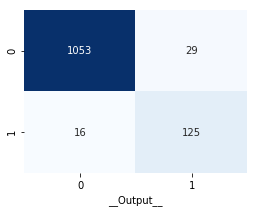

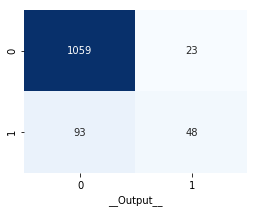

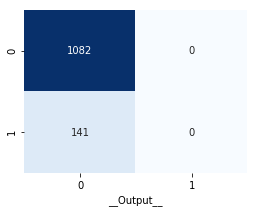

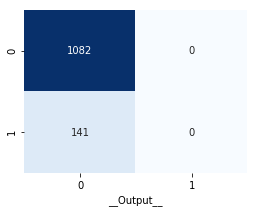

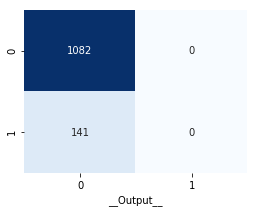

In [35]:
start_time = timeit.default_timer()

# Naive Bayes on Count Vectors
score1,result1 = train_model(MultinomialNB(), xtrain_count, train_yp, xvalid_count, valid_yp)
#print("NB, Count Vectors: ", score,result)

score2,result2 = train_model(MultinomialNB(), xtrain_count_char, train_yp, xvalid_count_char, valid_yp)
#print("NB, Count Vectors Char: ", score,result)

# Naive Bayes on Word Level TF IDF Vectors
score3,result3 = train_model(MultinomialNB(), xtrain_tfidf, train_yp, xvalid_tfidf, valid_yp)
#print("NB, WordLevel TF-IDF: ", score,result)

# Naive Bayes on Ngram Level TF IDF Vectors
score4,result4 = train_model(MultinomialNB(), xtrain_tfidf_ngram, train_yp, xvalid_tfidf_ngram, valid_yp)
#print("NB, N-Gram Vectors: ", score,result)

# Naive Bayes on Character Level TF IDF Vectors
score5,result5 = train_model(MultinomialNB(), xtrain_tfidf_ngram_chars, train_yp, xvalid_tfidf_ngram_chars, valid_yp)
#print("NB, CharLevel Vectors: ", score,result)

elapsed = timeit.default_timer() - start_time
time_keeper['NB_{}'.format(run_title)]=elapsed

In [36]:
# save joined results
names = ["NB, Count Vectors:","NB, Count Vectors Char: ","NB, WordLevel TF-IDF: ",
"NB, N-Gram Vectors: ","NB, CharLevel Vectors: "]
df_nb = score1.append(score2).append(score3).append(score4).append(score5)
names = list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_nb['class']))) for x in names))
df_nb[' ']=names
df_nb = df_nb.set_index(' ')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_nb.to_csv('Output/{}/nb_classification_report_{}_{}.csv'.format(run_title,run_title,time_), index = False)
df_nb

,class,f1_score,precision,recall,support,time_secs
,,,,,,
"NB, Count Vectors:",0,0.98,0.99,0.97,1082,0.003794
"NB, Count Vectors:",1,0.85,0.81,0.89,141,0.003794
"NB, Count Vectors Char:",0,0.95,0.92,0.98,1082,0.001655
"NB, Count Vectors Char:",1,0.45,0.68,0.34,141,0.001655
"NB, WordLevel TF-IDF:",0,0.94,0.88,1.00,1082,0.001487
"NB, WordLevel TF-IDF:",1,0.00,0.00,0.00,141,0.001487
"NB, N-Gram Vectors:",0,0.94,0.88,1.00,1082,0.004221
"NB, N-Gram Vectors:",1,0.00,0.00,0.00,141,0.004221
"NB, CharLevel Vectors:",0,0.94,0.88,1.00,1082,0.002649


### KNN


Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...


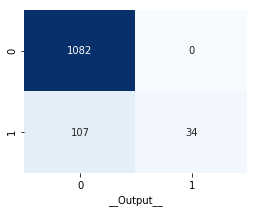

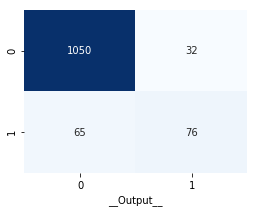

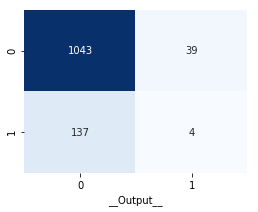

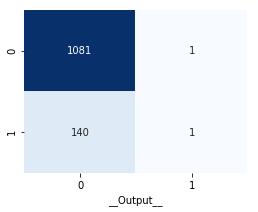

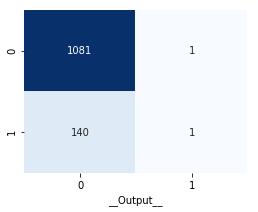

In [37]:
start_time = timeit.default_timer()

score1, result1 = train_model(KNeighborsClassifier(), xtrain_count, train_yp, xvalid_count, valid_yp)
# print("KNN, Count Vectors: ", score, result)

score2, result2 = train_model(KNeighborsClassifier(), xtrain_count_char, train_yp, xvalid_count_char, valid_yp)
# print("KNN, Count Vectors Char: ", score, result)

# Naive Bayes on Word Level TF IDF Vectors
score3, result3 = train_model(KNeighborsClassifier(), xtrain_tfidf, train_yp, xvalid_tfidf, valid_yp)
# print("KNN, WordLevel TF-IDF: ", score, result)

# Naive Bayes on Ngram Level TF IDF Vectors
score4, result4 = train_model(KNeighborsClassifier(), xtrain_tfidf_ngram, train_yp, xvalid_tfidf_ngram, valid_yp)
# print("KNN, N-Gram Vectors: ", score, result)

# Naive Bayes on Character Level TF IDF Vectors
score5, result5 = train_model(KNeighborsClassifier(), xtrain_tfidf_ngram_chars, train_yp, xvalid_tfidf_ngram_chars, valid_yp)
#print("KNN, CharLevel Vectors: ", score, result)

elapsed = timeit.default_timer() - start_time
time_keeper['KNN_{}'.format(run_title)]=elapsed

In [38]:
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_nb['class']))) for x in names))

In [39]:
# save joined results
names = ["KNN, Count Vectors:","KNN, Count Vectors Char: ","KNN, WordLevel TF-IDF: ","KNN, N-Gram Vectors: ","KNN, CharLevel Vectors: "]
df_knn = score1.append(score2).append(score3).append(score4).append(score5)
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_knn['class']))) for x in names))
df_knn['Model_Vec']=names
df_knn = df_knn.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_knn.to_csv('Output/{}/knn_classification_report_{}_knn_{}.csv'.format(run_title,run_title,time_))
df_knn

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
"KNN, Count Vectors:",0,0.95,0.91,1.00,1082,0.174818
"KNN, Count Vectors:",1,0.39,1.00,0.24,141,0.174818
"KNN, Count Vectors Char:",0,0.96,0.94,0.97,1082,0.270580
"KNN, Count Vectors Char:",1,0.61,0.70,0.54,141,0.270580
"KNN, WordLevel TF-IDF:",0,0.92,0.88,0.96,1082,0.112583
"KNN, WordLevel TF-IDF:",1,0.04,0.09,0.03,141,0.112583
"KNN, N-Gram Vectors:",0,0.94,0.89,1.00,1082,0.103053
"KNN, N-Gram Vectors:",1,0.01,0.50,0.01,141,0.103053
"KNN, CharLevel Vectors:",0,0.94,0.89,1.00,1082,0.100930


### SVM

Running model...
Fetching report...
Running model...


/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...


/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Fetching report...


/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


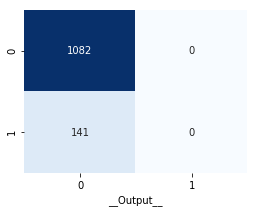

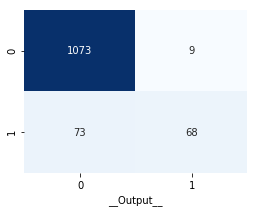

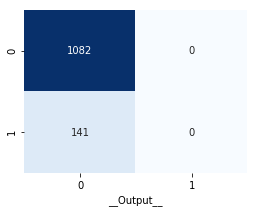

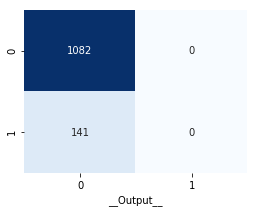

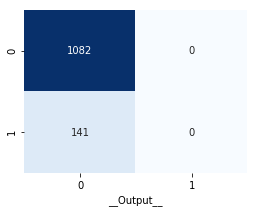

In [40]:
# SVM N-Gram Chars on TF IDF Vectors

start_time = timeit.default_timer()

score1,result1 = train_model(SVC(), xtrain_count, train_yp, xvalid_count, valid_yp)
# print("SVM, Count Vectors: ", score,result)

score2,result2 = train_model(SVC(), xtrain_count_char, train_yp, xvalid_count_char, valid_yp)
# print("SVM, Count Vectors Char: ", score,result)

# SVM on Word Level TF IDF Vectors
score3,result3 = train_model(SVC(), xtrain_tfidf, train_yp, xvalid_tfidf, valid_yp)
# print("SVM, WordLevel TF-IDF: ", score,result)

# SVM on Ngram Level TF IDF Vectors
score4,result4 = train_model(SVC(), xtrain_tfidf_ngram, train_yp, xvalid_tfidf_ngram, valid_yp)
# print("SVM, N-Gram Vectors: ", score,result)

# SVM on Character Level TF IDF Vectors
score5,result5 = train_model(SVC(), xtrain_tfidf_ngram_chars, train_yp, xvalid_tfidf_ngram_chars, valid_yp)
#print("SVM, CharLevel Vectors: ", score,result)

elapsed = timeit.default_timer() - start_time
time_keeper['SVM_{}'.format(run_title)]=elapsed

In [41]:
# save joined results
names = ["SVM, Count Vectors:","SVM, Count Vectors Char: ",
"SVM, WordLevel TF-IDF: ","SVM, N-Gram Vectors: ","SVM, CharLevel Vectors: "]
df_svm = score1.append(score2).append(score3).append(score4).append(score5)
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_knn['class']))) for x in names))
df_svm['Model_Vec']=names
df_svm = df_svm.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_svm.to_csv('Output/{}/svm_classification_report_{}_svm_{}.csv'.format(run_title,run_title, time_))
df_svm

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
"SVM, Count Vectors:",0,0.94,0.88,1.00,1082,0.340835
"SVM, Count Vectors:",1,0.00,0.00,0.00,141,0.340835
"SVM, Count Vectors Char:",0,0.96,0.94,0.99,1082,0.742087
"SVM, Count Vectors Char:",1,0.62,0.88,0.48,141,0.742087
"SVM, WordLevel TF-IDF:",0,0.94,0.88,1.00,1082,0.296213
"SVM, WordLevel TF-IDF:",1,0.00,0.00,0.00,141,0.296213
"SVM, N-Gram Vectors:",0,0.94,0.88,1.00,1082,0.131726
"SVM, N-Gram Vectors:",1,0.00,0.00,0.00,141,0.131726
"SVM, CharLevel Vectors:",0,0.94,0.88,1.00,1082,0.133356


#### SVM experiments

#### SVM grid search cv

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.2s finished


0 params - {'vect__ngram_range': (1, 1)}; mean - 0.93; std - 0.01
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.95; std - 0.01


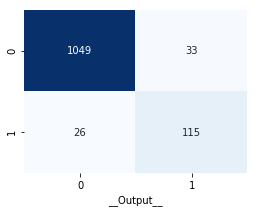

In [42]:
start_time = timeit.default_timer()

#
from sklearn.svm import LinearSVC

pipeline = Pipeline([
        ('vect', TfidfVectorizer(min_df=3, max_df=0.95)),
        ('clf', LinearSVC(C=1000)),
    ])

# TASK: Build a grid search to find out whether unigrams or bigrams are
# more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
}
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=kfolds,verbose=1)
grid_search.fit(train_xp, train_yp)

# TASK: print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

y_predicted = grid_search.predict(valid_xp)

# Print the classification report
report = classification_report(valid_yp, y_predicted)

# Print and plot the confusion matrix
plot_confusion_matrix(valid_yp, y_predicted)

df_svc = classification_report_out(report,run_title)

# df_svc['Model_Vec']=names
# df_svc = df_svm.set_index('Model_Vec')
# df_svc.to_csv('classification_report_climate_reuters_svc.csv')
elapsed = timeit.default_timer() - start_time
time_keeper['SVC_exp.2.grid_{}'.format(run_title)]=elapsed

df_svc

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   50.1s finished


             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1099
          1       0.96      0.89      0.92       124

avg / total       0.98      0.98      0.98      1223



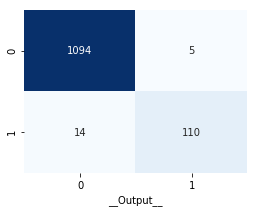

In [43]:
# en_stopwords = set(stopwords.words("english")) 
from text_processing import tokenizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenizer,
    lowercase = True,
    ngram_range=(1, 1),
    stop_words = stopwords.words('english'))

kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))


grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(train_x, train_y)
grid_svm.score(valid_x, valid_y)


predictions_svm_ = grid_svm.predict(valid_x)
cm = confusion_matrix(valid_y, predictions_svm_)
report=classification_report(valid_y,predictions_svm_))
plot_confusion_matrix(valid_y, predictions_svm_)
df_svm = classification_report_out(report,run_title)
df_svm

In [ ]:
# inspect errors
# error_df = pd.DataFrame({'val_text':valid_x, 'val_true':valid_y, 'val_pred':predictions_svm_})
# error_df[(error_df['val_pred']!=error_df['val_true'])].sample(10)

### Logistic Regression

Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...


/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/silas/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


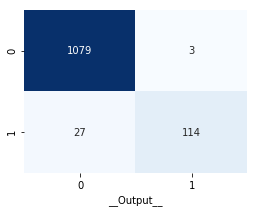

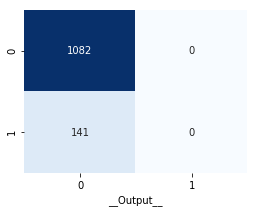

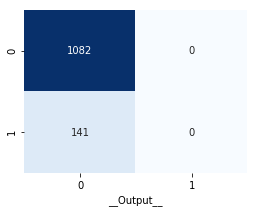

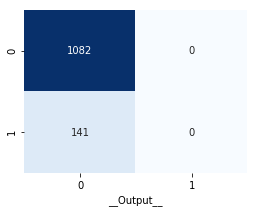

In [44]:
start_time = timeit.default_timer()

# Logistic Regression on Count Vectors
score1, result1 = train_model(LogisticRegression(), xtrain_count, train_yp, xvalid_count, valid_yp)
#print("LR, Count Vectors: ", accuracy)

# Logistic Regression on Word Level TF IDF Vectors
score2, result2 = train_model(LogisticRegression(), xtrain_tfidf, train_yp, xvalid_tfidf, valid_yp)
#print("LR, WordLevel TF-IDF: ", accuracy)

# Logistic Regression on Ngram Level TF IDF Vectors
score3, result3 = train_model(LogisticRegression(), xtrain_tfidf_ngram, train_yp, xvalid_tfidf_ngram, valid_yp)
#print("LR, N-Gram Vectors: ", accuracy)

# Logistic Regression on Character Level TF IDF Vectors
score4, result4 = train_model(LogisticRegression(), xtrain_tfidf_ngram_chars, train_yp, xvalid_tfidf_ngram_chars, valid_yp)
#print("LR, CharLevel Vectors: ", accuracy)

elapsed = timeit.default_timer() - start_time
time_keeper['Logistic_Regression_{}'.format(run_title)]=elapsed

In [45]:
# save joined results
names = ["LRM, Count Vectors:", "LRM, WordLevel TF-IDF: ","LRM, N-Gram Vectors: ","LRM, CharLevel Vectors: "]
df_LRM = score1.append(score2).append(score3).append(score4)
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_LRM['class']))) for x in names))
df_LRM['Model_Vec']=names
df_LRM = df_LRM.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_LRM.to_csv('Output/{}/LRM_classification_report_{}_{}.csv'.format(run_title,run_title,time_))
df_LRM

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
"LRM, Count Vectors:",0,0.99,0.98,1.00,1082,0.345158
"LRM, Count Vectors:",1,0.88,0.97,0.81,141,0.345158
"LRM, WordLevel TF-IDF:",0,0.94,0.88,1.00,1082,0.013362
"LRM, WordLevel TF-IDF:",1,0.00,0.00,0.00,141,0.013362
"LRM, N-Gram Vectors:",0,0.94,0.88,1.00,1082,0.013052
"LRM, N-Gram Vectors:",1,0.00,0.00,0.00,141,0.013052
"LRM, CharLevel Vectors:",0,0.94,0.88,1.00,1082,0.013093
"LRM, CharLevel Vectors:",1,0.00,0.00,0.00,141,0.013093


### Random Forest

Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...
Running model...
Fetching report...


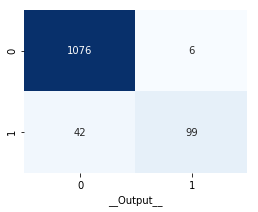

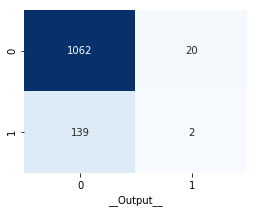

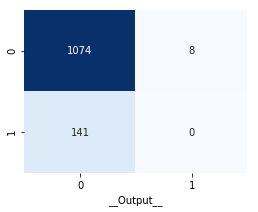

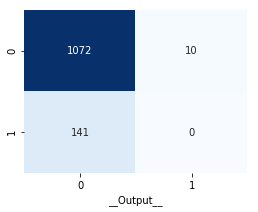

In [46]:
start_time = timeit.default_timer()

# Random Forest Classifier on Count Vectors
score1, result1 = train_model(ensemble.RandomForestClassifier(), xtrain_count, train_yp, xvalid_count, valid_yp)
#print("RF, Count Vectors: ", accuracy)

# Random Forest Classifier on Word Level TF IDF Vectors
score2, result2 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, train_yp, xvalid_tfidf, valid_yp)
#print("RF, WordLevel TF-IDF: ", accuracy)

# Random Forest Classifier on Ngram Level TF IDF Vectors
score3, result3 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, train_yp, xvalid_tfidf_ngram, valid_yp)
#print("RF, N-Gram Vectors: ", accuracy)

# Random Forest Classifier on Character Level TF IDF Vectors
score4, result4 = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, train_yp, xvalid_tfidf_ngram_chars, valid_yp)
#print("RF, CharLevel Vectors: ", accuracy)

elapsed = timeit.default_timer() - start_time
time_keeper['Random_Forest_{}'.format(run_title)]=elapsed

In [47]:
# save joined results
names = ["RF, Count Vectors:","RF, WordLevel TF-IDF: ","RF, N-Gram Vectors: ","RF, CharLevel Vectors: "]
df_RF = score1.append(score2).append(score3).append(score4)
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_RF['class']))) for x in names))
df_RF['Model_Vec']=names
df_RF = df_RF.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_RF.to_csv('Output/{}/RF_classification_report_{}.csv'.format(run_title,run_title,time_))
df_RF

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
"RF, Count Vectors:",0,0.98,0.96,0.99,1082,0.400150
"RF, Count Vectors:",1,0.80,0.94,0.70,141,0.400150
"RF, WordLevel TF-IDF:",0,0.93,0.88,0.98,1082,0.663493
"RF, WordLevel TF-IDF:",1,0.02,0.09,0.01,141,0.663493
"RF, N-Gram Vectors:",0,0.94,0.88,0.99,1082,2.621818
"RF, N-Gram Vectors:",1,0.00,0.00,0.00,141,2.621818
"RF, CharLevel Vectors:",0,0.93,0.88,0.99,1082,2.620380
"RF, CharLevel Vectors:",1,0.00,0.00,0.00,141,2.620380


### save and checkpoint

In [48]:
df_tk=pd.DataFrame.from_dict(time_keeper, orient='index', columns=['total_test_time_secs'])

In [49]:
df_tk.to_csv('Output/{}/{}_merged_run_times.csv'.format(run_title,run_title))

<a id='NNs'></a>
[inspect_train_models](#inspect_train_models)

## NNs

### Keras

In [21]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

In [22]:
from sklearn import metrics

### NN

Running model...
Train on 2932 samples, validate on 734 samples
Epoch 1/4
2932/2932 [==============================] - 3s 1ms/step - loss: 0.3606 - acc: 0.9335 - val_loss: 0.1605 - val_acc: 0.9741
Epoch 2/4
2932/2932 [==============================] - 1s 500us/step - loss: 0.0747 - acc: 0.9877 - val_loss: 0.0938 - val_acc: 0.9823
Epoch 3/4
2932/2932 [==============================] - 1s 492us/step - loss: 0.0278 - acc: 0.9956 - val_loss: 0.0856 - val_acc: 0.9823
Epoch 4/4
2932/2932 [==============================] - 1s 493us/step - loss: 0.0141 - acc: 0.9980 - val_loss: 0.0832 - val_acc: 0.9823
Fetching report...


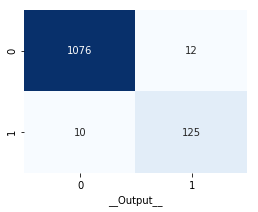

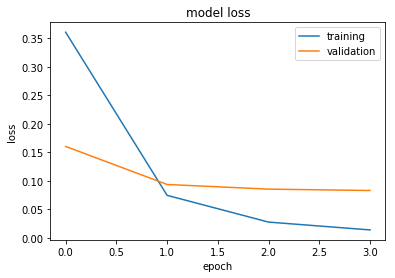

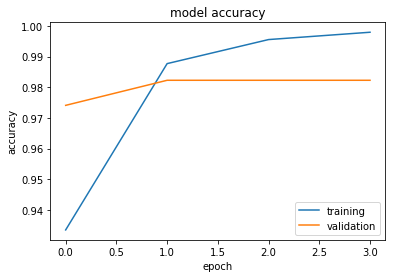

Running model...
Train on 2932 samples, validate on 734 samples
Epoch 1/4
2932/2932 [==============================] - 2s 550us/step - loss: 0.4488 - acc: 0.8741 - val_loss: 0.2628 - val_acc: 0.8992
Epoch 2/4
2932/2932 [==============================] - 1s 454us/step - loss: 0.1590 - acc: 0.9499 - val_loss: 0.1259 - val_acc: 0.9700
Epoch 3/4
2932/2932 [==============================] - 1s 431us/step - loss: 0.0601 - acc: 0.9901 - val_loss: 0.0916 - val_acc: 0.9782
Epoch 4/4
2932/2932 [==============================] - 1s 409us/step - loss: 0.0305 - acc: 0.9945 - val_loss: 0.0819 - val_acc: 0.9809
Fetching report...


<Figure size 432x288 with 0 Axes>

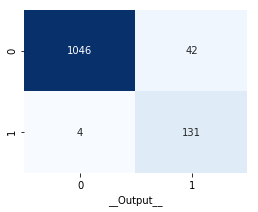

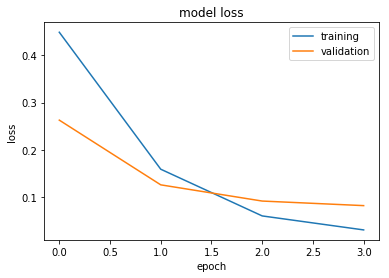

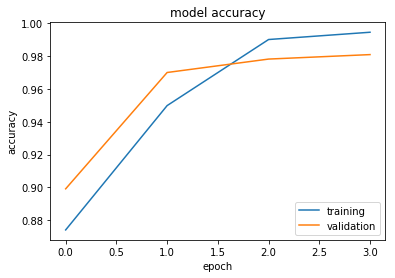

Running model...
Train on 2932 samples, validate on 734 samples
Epoch 1/4
2932/2932 [==============================] - 25s 9ms/step - loss: 0.5090 - acc: 0.8817 - val_loss: 0.3330 - val_acc: 0.8883
Epoch 2/4
2932/2932 [==============================] - 24s 8ms/step - loss: 0.1966 - acc: 0.9069 - val_loss: 0.2305 - val_acc: 0.9251
Epoch 3/4
2932/2932 [==============================] - 24s 8ms/step - loss: 0.0659 - acc: 0.9945 - val_loss: 0.1801 - val_acc: 0.9346
Epoch 4/4
2932/2932 [==============================] - 23s 8ms/step - loss: 0.0167 - acc: 0.9997 - val_loss: 0.1655 - val_acc: 0.9387
Fetching report...


<Figure size 432x288 with 0 Axes>

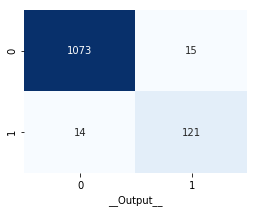

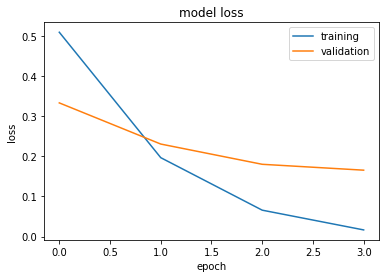

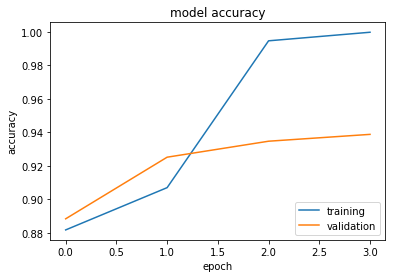

Running model...
Train on 2932 samples, validate on 734 samples
Epoch 1/4
2932/2932 [==============================] - 18s 6ms/step - loss: 0.5089 - acc: 0.8803 - val_loss: 0.3355 - val_acc: 0.8869
Epoch 2/4
2932/2932 [==============================] - 17s 6ms/step - loss: 0.2012 - acc: 0.8977 - val_loss: 0.2382 - val_acc: 0.9223
Epoch 3/4
2932/2932 [==============================] - 17s 6ms/step - loss: 0.0764 - acc: 0.9918 - val_loss: 0.1822 - val_acc: 0.9346
Epoch 4/4
2932/2932 [==============================] - 17s 6ms/step - loss: 0.0182 - acc: 0.9997 - val_loss: 0.1652 - val_acc: 0.9401
Fetching report...


<Figure size 432x288 with 0 Axes>

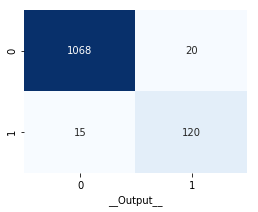

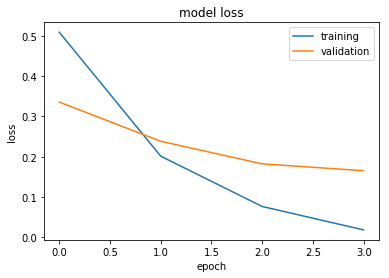

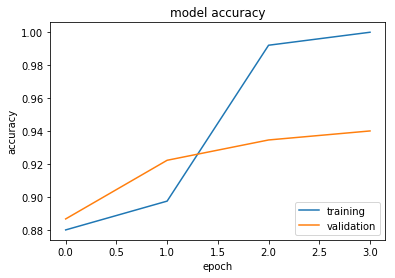

<Figure size 432x288 with 0 Axes>

In [23]:
start_time = timeit.default_timer()

def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(1, activation="sigmoid")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return classifier 

#classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
# score, result1 = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram,valid_y, is_neural_net=True)

# Neural net on Count Vectors
classifier = create_model_architecture(xtrain_count.shape[1])
score1, result1 = train_model(classifier, xtrain_count, train_y, xvalid_count, valid_y, is_neural_net=True)


# Neural net on Word Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf.shape[1])
score2, result2 = train_model(classifier, xtrain_tfidf, train_y, xvalid_tfidf, valid_y, is_neural_net=True)


# Neural net on Ngram Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram.shape[1])
score3, result3 = train_model(classifier, xtrain_tfidf_ngram, train_y, xvalid_tfidf_ngram, valid_y, is_neural_net=True)


# Neural net on Character Level TF IDF Vectors
classifier = create_model_architecture(xtrain_tfidf_ngram_chars.shape[1])
score4, result4 = train_model(classifier, xtrain_tfidf_ngram_chars, train_y, xvalid_tfidf_ngram_chars, valid_y, is_neural_net=True)


elapsed = timeit.default_timer() - start_time
time_keeper['Neural_Net_{}'.format(run_title)]=elapsed

In [24]:
# save joined results
names = ["NN, Count Vectors:","NN, WordLevel TF-IDF: ","NN, N-Gram Vectors: ","NN, CharLevel Vectors: "]
df_NN = score1.append(score2).append(score3).append(score4)
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(df_NN['class']))) for x in names))
df_NN['Model_Vec']=names
df_NN = df_NN.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_NN.to_csv('Output/{}/NN_classification_report_{}.csv'.format(run_title,run_title,time_))
df_NN

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
"NN, Count Vectors:",0,0.99,0.99,0.99,1088,8.048228
"NN, Count Vectors:",1,0.92,0.91,0.93,135,8.048228
"NN, WordLevel TF-IDF:",0,0.98,1.00,0.96,1088,5.858046
"NN, WordLevel TF-IDF:",1,0.85,0.76,0.97,135,5.858046
"NN, N-Gram Vectors:",0,0.99,0.99,0.99,1088,96.431761
"NN, N-Gram Vectors:",1,0.89,0.89,0.90,135,96.431761
"NN, CharLevel Vectors:",0,0.98,0.99,0.98,1088,69.009708
"NN, CharLevel Vectors:",1,0.87,0.86,0.89,135,69.009708


### Word Embeddings

In [7]:
from keras.preprocessing import text, sequence

# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('../Data/wiki-news-300d-1M.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer in keras
token = text.Tokenizer()
token.fit_on_texts(texts)
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

NameError: name 'texts' is not defined

###  CNN

Running model...
Train on 2932 samples, validate on 734 samples
Epoch 1/4
2932/2932 [==============================] - 7s 3ms/step - loss: 0.3239 - acc: 0.8779 - val_loss: 0.1804 - val_acc: 0.9387
Epoch 2/4
2932/2932 [==============================] - 6s 2ms/step - loss: 0.1096 - acc: 0.9714 - val_loss: 0.0920 - val_acc: 0.9755
Epoch 3/4
2932/2932 [==============================] - 6s 2ms/step - loss: 0.0558 - acc: 0.9836 - val_loss: 0.0841 - val_acc: 0.9782
Epoch 4/4
2932/2932 [==============================] - 6s 2ms/step - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0802 - val_acc: 0.9782
Fetching report...


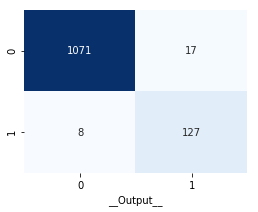

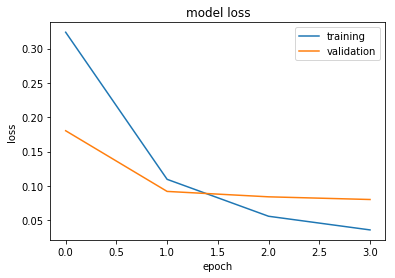

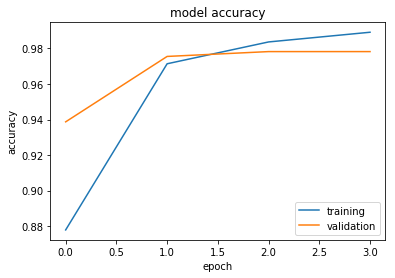

<Figure size 432x288 with 0 Axes>

In [34]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

classifier = create_cnn()
score1,result1 = train_model(classifier, train_seq_x, train_y, valid_seq_x, valid_y, is_neural_net=True)

In [44]:
names = ["CNN"]
df_CNN = score1
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(valid_y))) for x in names))
    
df_CNN['Model_Vec']=names
df_CNN=df_CNN.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_CNN.to_csv('Output/{}/CNN_classification_report_{}.csv'.format(run_title,run_title,time_))
df_CNN

,class,f1_score,precision,recall,support,time_secs
Model_Vec,,,,,,
CNN,0,0.99,0.99,0.98,1088,27.652806
CNN,1,0.91,0.88,0.94,135,27.652806


### LSTM

In [6]:
def create_rnn_lstm():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.LSTM(100)(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

classifier = create_rnn_lstm()
score1, result = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("RNN-LSTM, Word Embeddings",  accuracy)

NameError: name 'word_index' is not defined

In [ ]:
names = ["LSTM"]
df_LSTM = score1
names=list(itertools.chain.from_iterable(itertools.repeat(x, len(set(valid_y))) for x in names))
    
df_LSTM['Model_Vec']=names
df_LSTM=df_LSTM.set_index('Model_Vec')
time_=time.strftime("%a_%d_%b_%Y_%H:%M:%S", time.gmtime())
df_LSTM.to_csv('Output/{}/{}_classification_report_{}.csv'.format(run_title,run_title,time_))
df_LSTM

### Bidirectional RNN

In [ ]:
def create_bidirectional_rnn():
# Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the LSTM Layer
    lstm_layer = layers.Bidirectional(layers.GRU(100))(embedding_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(lstm_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_bidirectional_rnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("RNN-Bidirectional, Word Embeddings",  accuracy)

### RCNN

In [ ]:
def create_rcnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
    
    # Add the recurrent layer
    rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy')
    
    return model

classifier = create_rcnn()
accuracy = train_model(classifier, train_seq_x, train_y, valid_seq_x, is_neural_net=True)
print("CNN, Word Embeddings",  accuracy)

## Tensorflow - Logistic Regression

In [ ]:
# Start a graph session
sess = tf.Session()

batch_size = 200
max_features = 1000

In [ ]:
# Split up data set into train/test
train_indices = np.random.choice(sparse_tfidf_texts.shape[0], round(0.8*sparse_tfidf_texts.shape[0]), replace=False)
test_indices = np.array(list(set(range(sparse_tfidf_texts.shape[0])) - set(train_indices)))
texts_train = sparse_tfidf_texts[train_indices]
texts_test = sparse_tfidf_texts[test_indices]
target_train = np.array([x for ix, x in enumerate(labels) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(labels) if ix in test_indices])

In [ ]:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[max_features,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Initialize placeholders
x_data = tf.placeholder(shape=[None, max_features], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(x_data, A), b)

# Declare loss function (Cross Entropy loss)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=y_target))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, y_target), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.0025)
train_step = my_opt.minimize(loss)

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

# Start Logistic Regression
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(texts_train.shape[0], size=batch_size)
    rand_x = texts_train[rand_index].todense()
    rand_y = np.transpose([target_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        i_data.append(i+1)
        train_loss_temp = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(loss, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x, y_target: rand_y})
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict={x_data: texts_test.todense(), y_target: np.transpose([target_test])})
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))


# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## COMPARISON
- https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

In [ ]:
# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
'''
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = train_y
'''
X = NLP_DF
Y = train_y
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
from pandas.tools.plotting import table

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df)  # where df is your data frame

plt.savefig('mytable.png')